# Aug 31th, 2022 (Particip. Coeff.)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir

In [2]:
nn = 512
perc = 15
fig_dir = 'Figs_Supp'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}-p{perc}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512-p15/Figs_Supp

In [3]:
os.listdir(fig_dir)

[
    'ent_deg_perc.png',
    'carto.png',
    'Disj_CAF.png',
    'Disj_BOLD.png',
    'carto.pdf',
    'Disj_CAS.png'
]

## Prepare (512)

In [4]:
num_k = 7
mice = Mice(nn)
bt_dict, props_bo, props_ca = default_props(mice, num_k, perc=15)
bt = BootStrap(**props_ca)
pal = prepare_palette()

## Degree

In [5]:
for mode, o in bt_dict.items():
    o.run_deg = np.array(o.run_deg)
    o.run_deg[o.run_deg == 0] = np.nan

In [6]:
%%time

cut, se, bins, xs = cut4figs('deg', bt_dict, bt.get_booter(int(1e5)))
len(xs), len(bins)

CPU times: user 6.63 s, sys: 51.9 ms, total: 6.68 s
Wall time: 6.68 s


(69, 70)

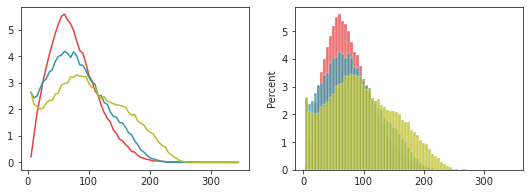

In [7]:
fig, axes = create_figure(1, 2, (9, 3))
for mode, o in bt_dict.items():
    axes[0].plot(xs, avg(cut[mode], 1), color=pal[mode])
    sns.histplot(
        data=o.run_deg[np.isfinite(o.run_deg)],
        bins=bins,
        stat='percent',
        color=pal[mode],
        ax=axes[1],
    )

In [8]:
deg_avg = {
    mode: avg(o.run_deg, 1) for
    mode, o in bt_dict.items()
}

In [9]:
{k: (np.round(np.nanmin(v)), np.round(np.nanmax(v))) for k, v in deg_avg.items()}

{
    'BOLD': (29.0, 125.0),
    'Ca$^{2\\!\\!+}_{slow}$': (17.0, 159.0),
    'Ca$^{2\\!\\!+}_{fast}$': (1.0, 198.0)
}

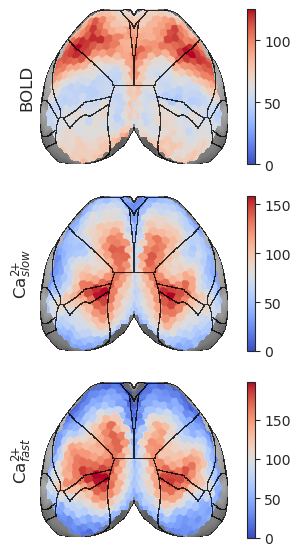

In [10]:
_ = bt.show(
    data=deg_avg,
    figsize=(5, 7),
    vmin=0,
    vmax=None,
    add_disjoint=False,
    contour_cmap='Greys_r',
    cmap='coolwarm',
    cbar=True,
)

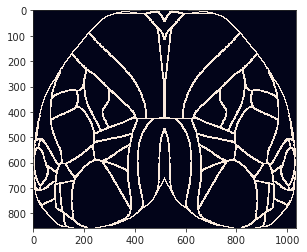

In [11]:
contour = bt.get_contour(0.2, False)
plt.imshow(contour);

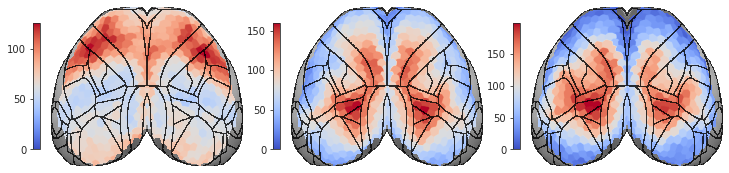

In [13]:
fig, axes = create_figure(1, 3, (10, 3), tight_layout=False, constrained_layout=True)
for ax, (mode, x) in zip(axes.flat, deg_avg.items()):
    x[x == 0] = np.nan
    
    if mode == BOLD:
        vmin = 0
        nbins = 4
    elif mode == CAS:
        vmin = 0
        nbins = 6
    elif mode == CAF:
        vmin = 0
        nbins = 6
    else:
        raise NotImplementedError
    vmax = np.nanmax(x)
    
    ax, cbar = ctx2ax(
        x=x,
        ax=ax,
        base=bt,
        vmin=vmin,
        vmax=vmax,
        cmap='coolwarm',
        cbar_shrink=0.6,
        contour=contour,
        contour_cmap='Greys_r',
        cbar_tick_nbins=nbins,
        cbar_aspect=20,
    )
remove_ticks(axes)

# fig.savefig(pjoin(fig_dir, 'ctx.png'), **kws_fig)

plt.show()

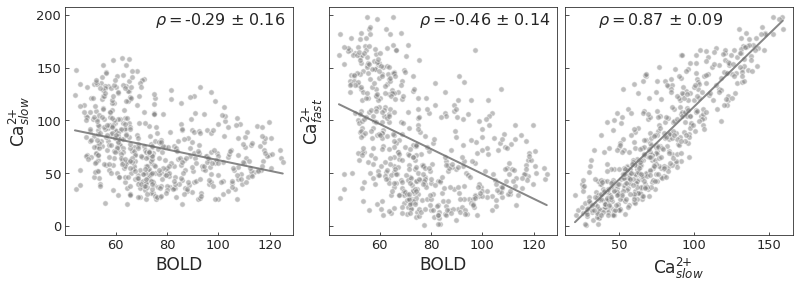

In [14]:
fig, _ = pairwise_lite(
    attr='deg',
    bt_dict=bt_dict,
    good=git_good('deg', bt_dict),
    n_resamples=int(1e3),
)
# fig.savefig(pjoin(fig_dir, 'pw.pdf'), **kws_fig)
# fig.savefig(pjoin(fig_dir, 'pw.png'), **kws_fig)

## Main analysis

### Get Adjs

In [15]:
adj = {}

mice.set_band()
kwargs = {
    'task': 'rest',
    'desc': {'bold': 'bp(0.01,0.5)'},
}
adj[BOLD] = collect_adjacencies(mice, 'bold-lite', **kwargs)[0]

b = (0.01, 0.5)
mice.set_band(band_ca=b)
kwargs = {
    'task': 'rest',
    'desc': {'ca2': f'bp{b}'.replace(' ', '')},
}
adj[CAS] = collect_adjacencies(mice, 'ca2', **kwargs)[0]

b = (0.5, 5.0)
mice.set_band(band_ca=b)
kwargs = {
    'task': 'rest',
    'desc': {'ca2': f'bp{b}'.replace(' ', '')},
}
adj[CAF] = collect_adjacencies(mice, 'ca2', **kwargs)[0]

In [43]:
# Adjacencies binary
adj_bin = {
    mode: np_nans((
        mice.cfg.n_subjects,
        mice.cfg.n_sessions,
        4,
        len(o.n2l),
        len(o.n2l),
    )) for mode, o in bt_dict.items()
}
for mode, a_all in adj.items():
    for ii, a in enumerate(a_all):
        thres = calculate_threshold(a, perc / 100)
        thres = thres.pop()
        _a = a.copy()
        _a[a <= thres] = 0
        _a[a > thres] = 1
        i, j, k = list(bt_dict[mode].address.values())[ii]
        adj_bin[mode][i, j, k] = _a
        
# Degree binary
deg = {
    k: bn.nansum(v, -1) for
    k, v in adj_bin.items()
}
deg_avg = {}
for k, v in deg.items():
    x = v.copy()
    x[x == 0] = np.nan
    deg_avg[k] = avg(x, 1)

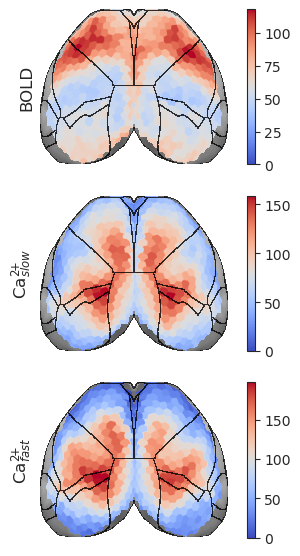

In [44]:
_ = bt.show(
    data=deg_avg,
    figsize=(5, 7),
    vmin=0,
    vmax=None,
    add_disjoint=False,
    contour_cmap='Greys_r',
    cmap='coolwarm',
    cbar=True,
)

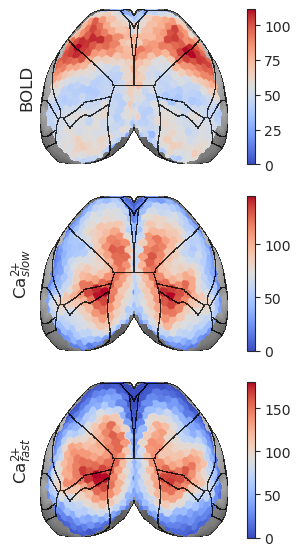

In [45]:
_ = bt.show(
    data={k: avg(v, 1) for k, v in deg.items()},
    figsize=(5, 7),
    vmin=0,
    vmax=None,
    add_disjoint=False,
    contour_cmap='Greys_r',
    cmap='coolwarm',
    cbar=True,
)

In [46]:
{k: (np.round(np.nanmin(v)), np.round(np.nanmax(v))) for k, v in deg_avg.items()}

{
    'BOLD': (26.0, 118.0),
    'Ca$^{2\\!\\!+}_{slow}$': (17.0, 159.0),
    'Ca$^{2\\!\\!+}_{fast}$': (1.0, 198.0)
}

### Get partition

In [47]:
results = similiarity_results(
    mice=mice,
    perc=perc,
    num_k=num_k,
    merge_thres=0.444,
    n_resamples=None,
)
partition = {}
for mode, o in results['bt_dict'].items():
    partition[mode] = o.get_disjoint_community()

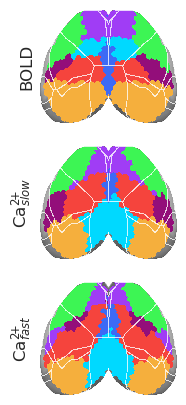

In [48]:
_ = bt.show(partition, vmin=1, vmax=7, cmap=get_cluster_cmap(range(7)), interp='none')

### Get $\kappa$

In [111]:
p = {}
for mode, a in adj_bin.items():
    pt = partition[mode]
    shape = np.array(a.shape)
    shape[-2] = num_k
    kappa = np_nans(shape)
    
    for i, oc_idx in enumerate(np.unique(pt[np.isfinite(pt)])):
        nodes = pt == oc_idx
        kappa[..., i, :] = bn.nansum(a[..., nodes], -1)
    assert np.array_equal(bn.nansum(kappa, -2), deg[mode], equal_nan=True)

    x = kappa / np.nansum(kappa, -2, keepdims=True)
    p[mode] = 1 - bn.nansum(x ** 2, -2)

In [114]:
{k: v.shape for k, v in p.items()}

{
    'BOLD': (10, 3, 4, 542),
    'Ca$^{2\\!\\!+}_{slow}$': (10, 3, 4, 542),
    'Ca$^{2\\!\\!+}_{fast}$': (10, 3, 4, 542)
}

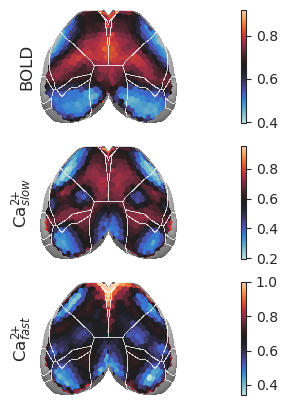

In [121]:
_ = bt.show(
    data={k: avg(v, 1) for k, v in p.items()},
    vmin=None,
    vmax=None,
    cmap='icefire',
    cbar=True,
)

In [122]:
%%time

for mode, o in bt_dict.items():
    _ = o.compute_entropy(
        use_prune=True,
        select_seeds=False,
       # select_seeds=True if
       #  mode == BOLD else False,
    )

CPU times: user 9.12 s, sys: 2.88 s, total: 12 s
Wall time: 12 s


<AxesSubplot:>

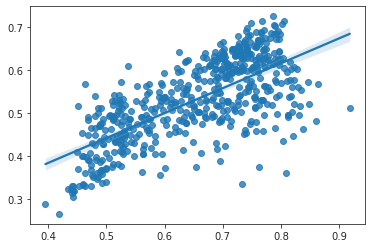

In [128]:
sns.regplot(avg(p[BOLD], 1), avg(bt_dict[BOLD].run_h, 1))

In [135]:
mode = BOLD
sp_stats.pearsonr(avg(p[mode], 1), avg(bt_dict[mode].run_h, 1))

(0.6922203928542371, 1.5942548177358641e-78)

In [138]:
mode = CAS
sp_stats.pearsonr(avg(p[mode], 1), avg(bt_dict[mode].run_h, 1))

(0.7373664661801083, 4.5964664944594244e-94)

In [133]:
mode = CAF
good = np.isfinite(avg(bt_dict[mode].run_h, 1))
sp_stats.pearsonr(avg(p[mode], 1)[good], avg(bt_dict[mode].run_h, 1)[good])

(0.1992736710758805, 3.7779121907371163e-06)

In [146]:
adj_avg = {k: avg(v) for k, v in adj.items()}
adj_avg_bin = {}
for mode, a in adj_avg.items():
    thres = calculate_threshold(a, perc / 100)
    thres = thres.pop()
    _a = a.copy()
    _a[a <= thres] = 0
    _a[a > thres] = 1
    adj_avg_bin[mode] = _a
{k: v.shape for k, v in adj_avg_bin.items()}

{
    'BOLD': (542, 542),
    'Ca$^{2\\!\\!+}_{slow}$': (542, 542),
    'Ca$^{2\\!\\!+}_{fast}$': (542, 542)
}

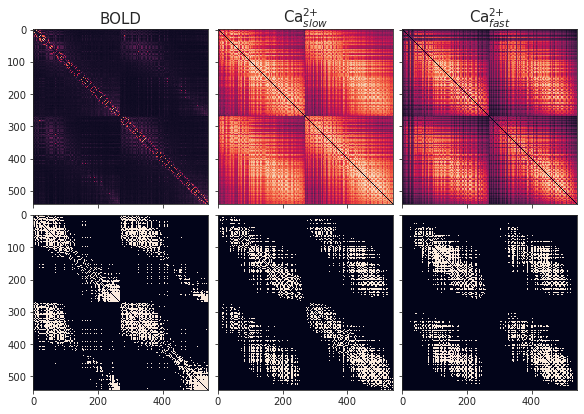

In [162]:
fig, axes = create_figure(2, 3, (8, 5.6), 'all', 'all', constrained_layout=True)
for i, mode in enumerate(bt_dict):
    ax = axes[0, i]
    ax.set_title(mode, fontsize=15)
    ax.imshow(adj_avg[mode])
    
    ax = axes[1, i]
    ax.imshow(adj_avg_bin[mode])

In [164]:
p = {}
for mode, a in adj_avg_bin.items():
    pt = partition[mode]
    kappa = np_nans((num_k, len(pt)))
    
    for i, oc_idx in enumerate(np.unique(pt[np.isfinite(pt)])):
        nodes = pt == oc_idx
        kappa[i] = bn.nansum(a[nodes], 0)

    x = kappa / np.nansum(kappa, -2, keepdims=True)
    p[mode] = 1 - bn.nansum(x ** 2, -2)

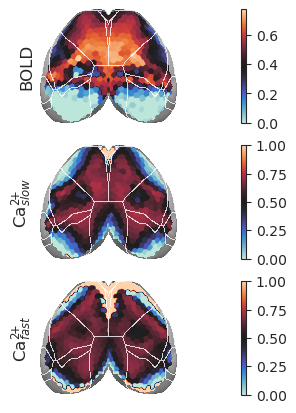

In [166]:
_ = bt.show(
    data={k: avg(v, 1) for k, v in p.items()},
    vmin=None,
    vmax=None,
    cmap='icefire',
    cbar=True,
)